In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, inv
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_blobs
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

Ex 1

In [5]:
def leverage_scores_analysis(mean, std, e_mean, e_std):
    a = 2
    b = 4
    n = 500
    
    x = np.random.normal(loc=mean, scale=std, size=n)
    e = np.random.normal(loc=e_mean, scale=e_std, size=n)

    y = x*a + b + e

    X = np.vstack((np.ones(n), x)).T

    XtX = X.T @ X
    L = cholesky(XtX)
    L_inv = inv(L)
    XtX_inv = L_inv.T @ L_inv

    H = X @ XtX_inv @ X.T
    
    leverage_scores = [H[i][i] for i in range(n)]
    threshold = np.quantile(leverage_scores, 0.9)
    anomalies = leverage_scores > threshold

    plt.scatter(x[~anomalies], y[~anomalies], color="blue")
    plt.scatter(x[anomalies], y[anomalies], color="red", edgecolor="red")
    plt.show()

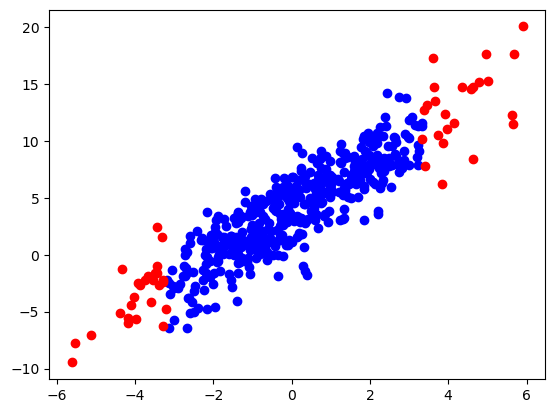

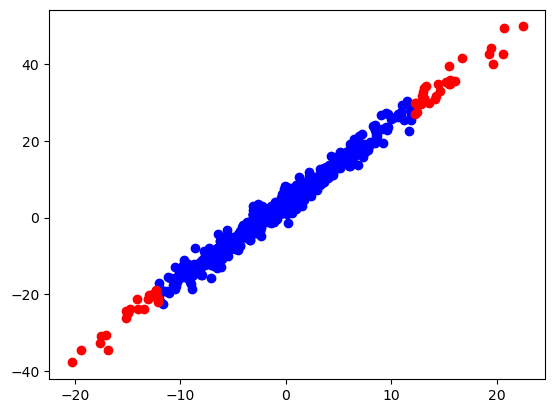

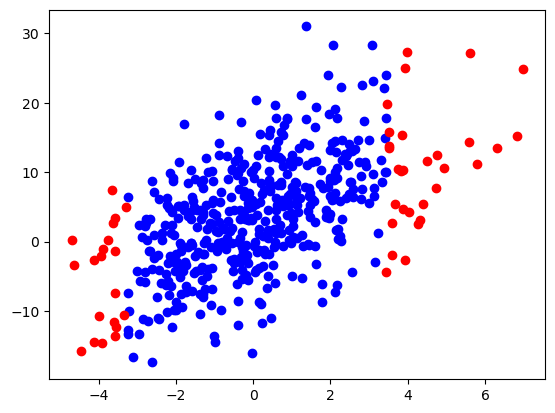

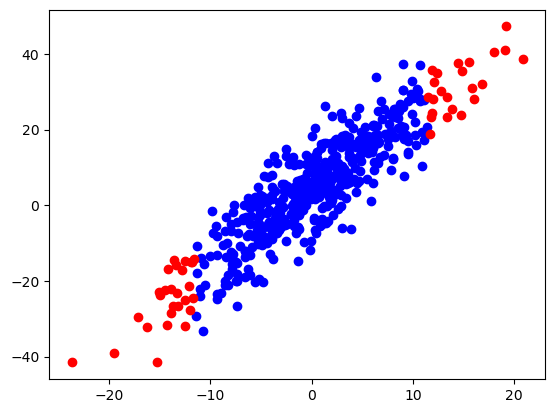

In [7]:
leverage_scores_analysis(mean=0, std=2, e_mean=0, e_std=2) # normal
leverage_scores_analysis(mean=0, std=7, e_mean=0, e_std=2) # high variance on x
leverage_scores_analysis(mean=0, std=2, e_mean=0, e_std=7) # high variance on y
leverage_scores_analysis(mean=0, std=7, e_mean=0, e_std=7) # high variance on x and y

In [9]:
def leverage_scores_analysis_2(mean1, std1, mean2, std2, e_mean, e_std):
    a = 2
    b = 4
    c = 5  
    n = 500
    
    x1 = np.random.normal(loc=mean1, scale=std1, size=n)
    x2 = np.random.normal(loc=mean2, scale=std2, size=n)
    e = np.random.normal(loc=e_mean, scale=e_std, size=n)
    
    y = a * x1 + b * x2 + c + e
    
    X = np.vstack((np.ones(n), x1, x2)).T
    
    XtX = X.T @ X
    L = cholesky(XtX)
    L_inv = inv(L)
    XtX_inv = L_inv.T @ L_inv
    H = X @ XtX_inv @ X.T
    
    leverage_scores = [H[i][i] for i in range(n)]
    threshold = np.quantile(leverage_scores, 0.95)
    anomalies = leverage_scores > threshold

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    plt.scatter(x1[~anomalies], x2[~anomalies], y[~anomalies], color="blue")
    plt.scatter(x1[anomalies], x2[anomalies], y[anomalies], color="red")
    plt.show()

C:\Users\Maria\anaconda3\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


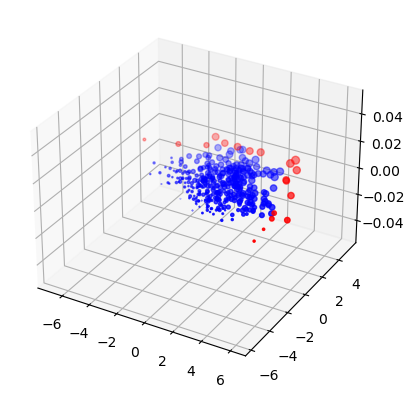

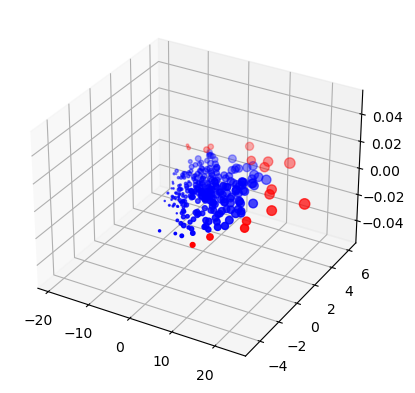

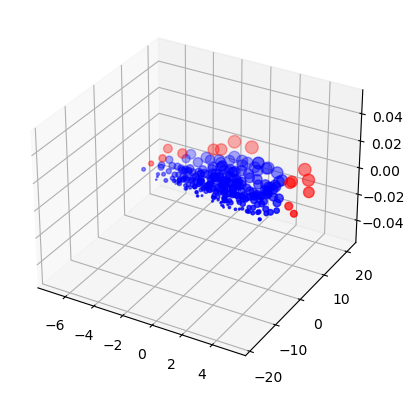

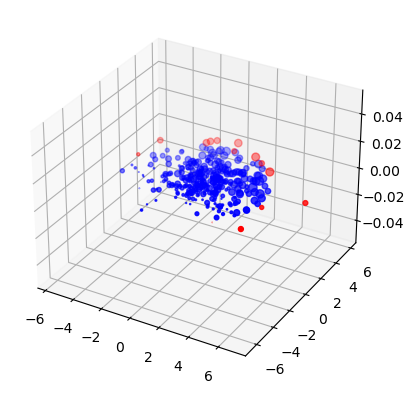

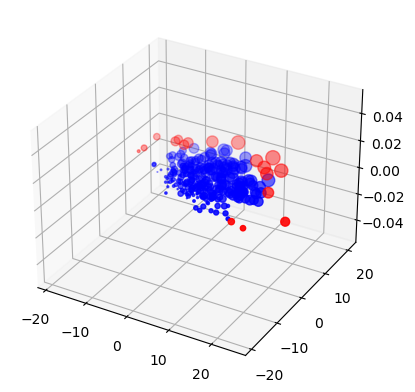

In [11]:
leverage_scores_analysis_2(mean1=0, std1=2, mean2=0, std2=2, e_mean=0, e_std=2)  # Normal
leverage_scores_analysis_2(mean1=0, std1=7, mean2=0, std2=2, e_mean=0, e_std=2)  # High variance on x1
leverage_scores_analysis_2(mean1=0, std1=2, mean2=0, std2=7, e_mean=0, e_std=2)  # High variance on x2
leverage_scores_analysis_2(mean1=0, std1=2, mean2=0, std2=2, e_mean=0, e_std=7)  # High variance on y
leverage_scores_analysis_2(mean1=0, std1=7, mean2=0, std2=7, e_mean=0, e_std=7)  # High variance on x1, x2, and y

Ex 2

In [14]:
x_train, x_test, y_train, y_test = generate_data_clusters(
    n_train=400,
    n_test=200,
    n_clusters=2,
    n_features=2,
    contamination=0.1
)

In [16]:
def knn(n_neighbors):
    knn = KNN(n_neighbors=n_neighbors, contamination=0.1)
    knn.fit(x_train)

    y_train_pred = knn.predict(x_train)
    y_test_pred = knn.predict(x_test)

    train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    test_accuracy = balanced_accuracy_score(y_test, y_test_pred)

    return y_train_pred, y_test_pred, train_accuracy, test_accuracy

In [18]:
def plot_results(x, y, title):
    plt.figure(figsize=(5, 4))

    plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], color='green')
    plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='red')

    plt.title(title)
    plt.show()

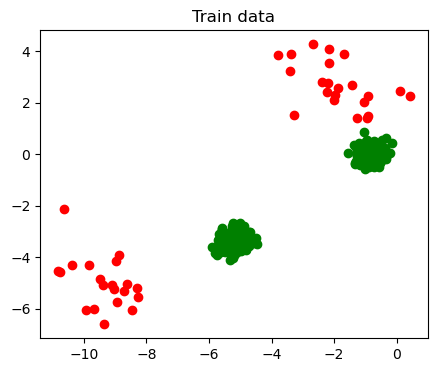

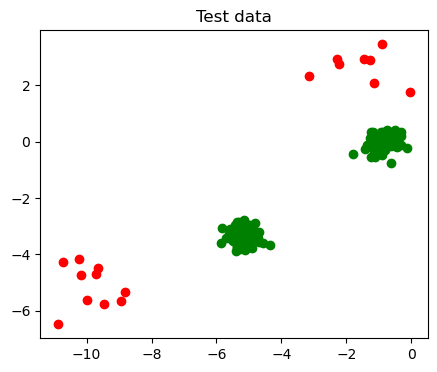

In [20]:
plot_results(x_train, y_train, "Train data")
plot_results(x_test, y_test, "Test data")

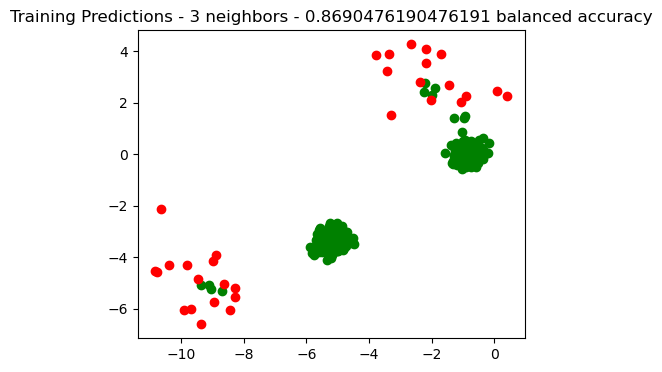

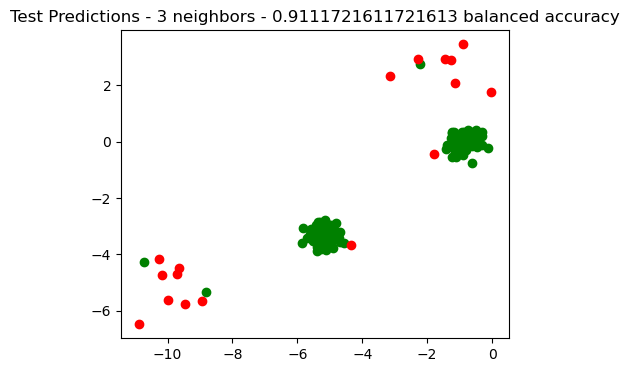

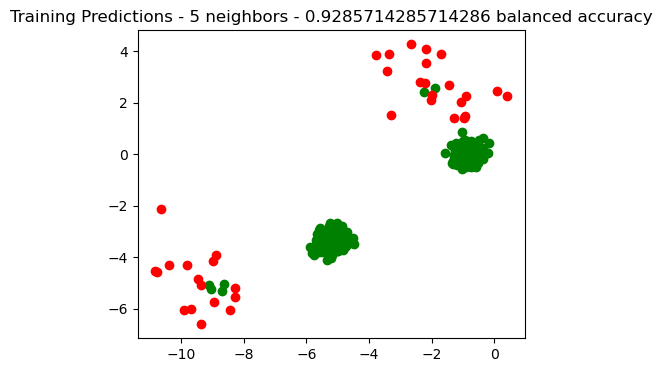

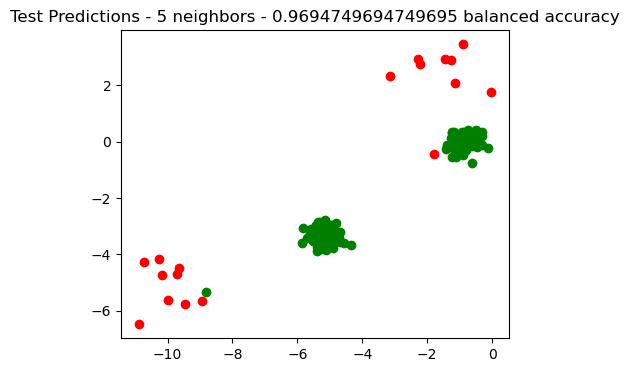

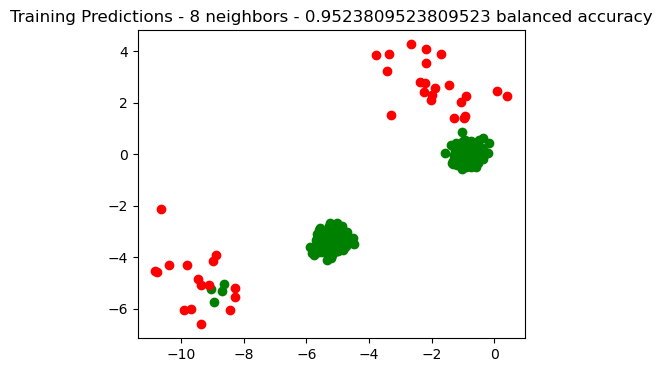

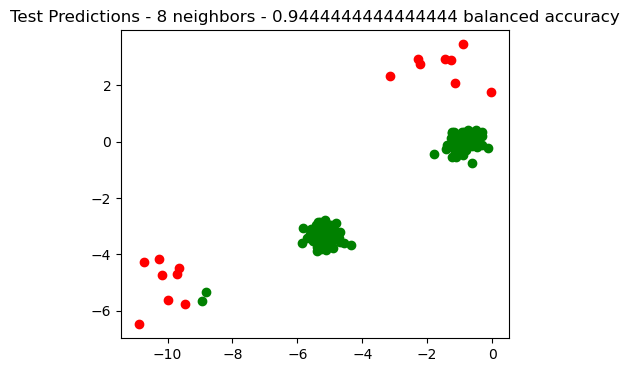

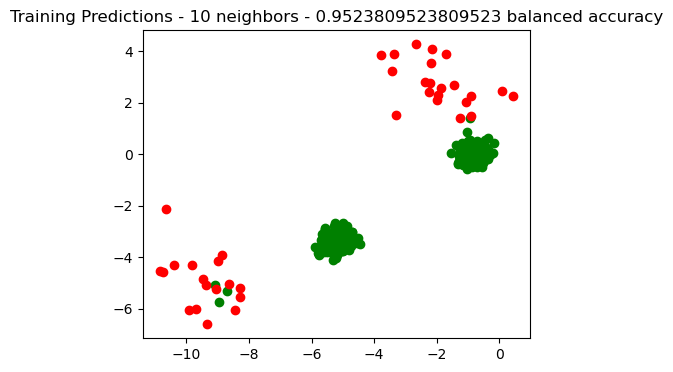

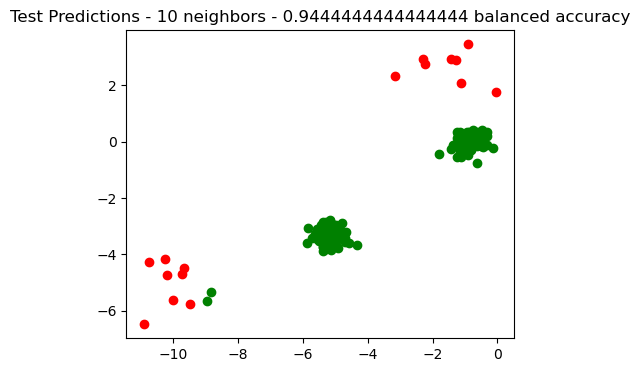

In [24]:
n_neighbors = [3, 5, 8, 10]
for nn in n_neighbors:
    y_train_pred, y_test_pred, train_accuracy, test_accuracy = knn(nn)
    plot_results(x_train, y_train_pred, f'Training Predictions - {nn} neighbors - {train_accuracy} balanced accuracy')
    plot_results(x_test, y_test_pred, f'Test Predictions - {nn} neighbors - {test_accuracy} balanced accuracy')

Ex 3

In [27]:
x, y = make_blobs(n_samples=[200, 100], n_features=2, centers=[[-10, -10], [10, 10]], cluster_std=[2, 6])

In [29]:
def knn(n_neighbors):
    knn_model = KNN(n_neighbors=n_neighbors, contamination=0.07)
    knn_model.fit(x)
    
    y_pred = knn_model.predict(x)
    return y_pred

def lof(n_neighbors):
    lof_model = LOF(n_neighbors=n_neighbors, contamination=0.07)
    lof_model.fit(x)

    y_pred = lof_model.predict(x)
    return y_pred

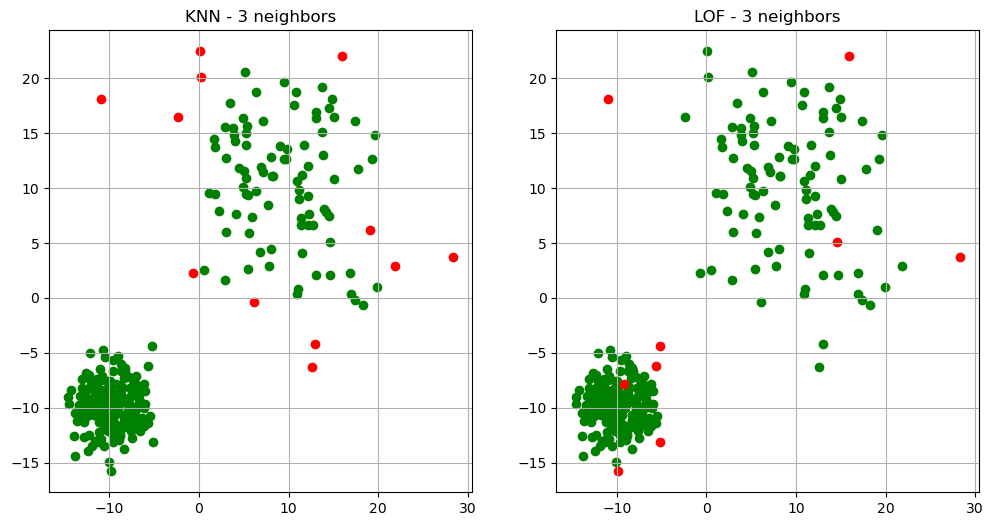

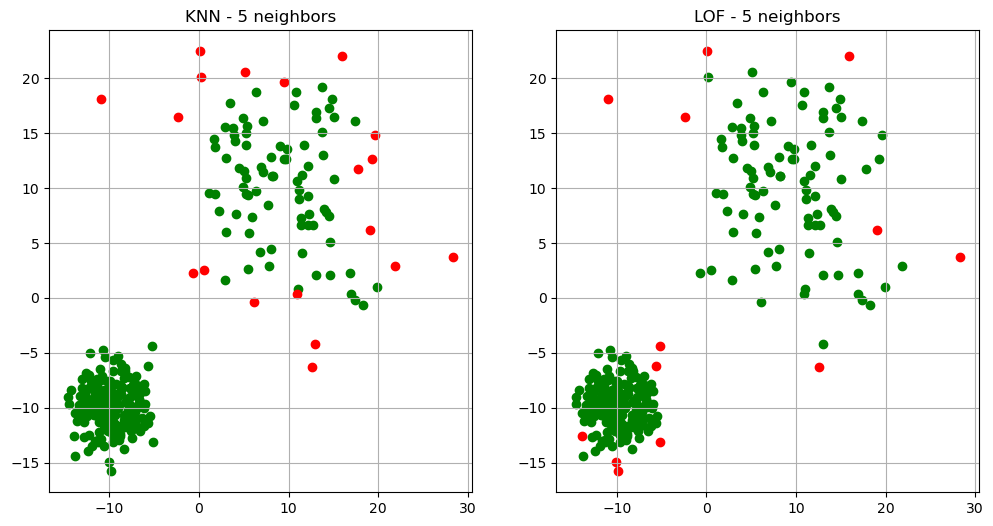

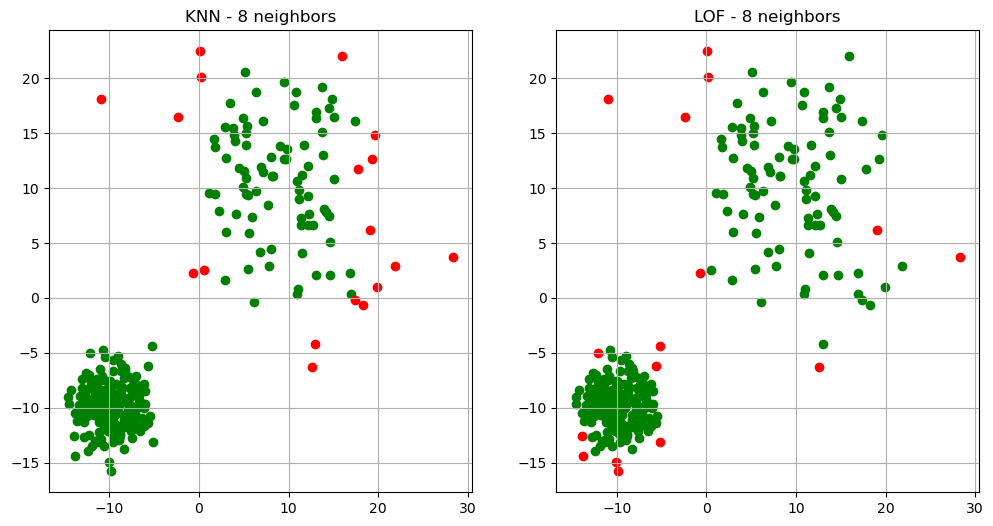

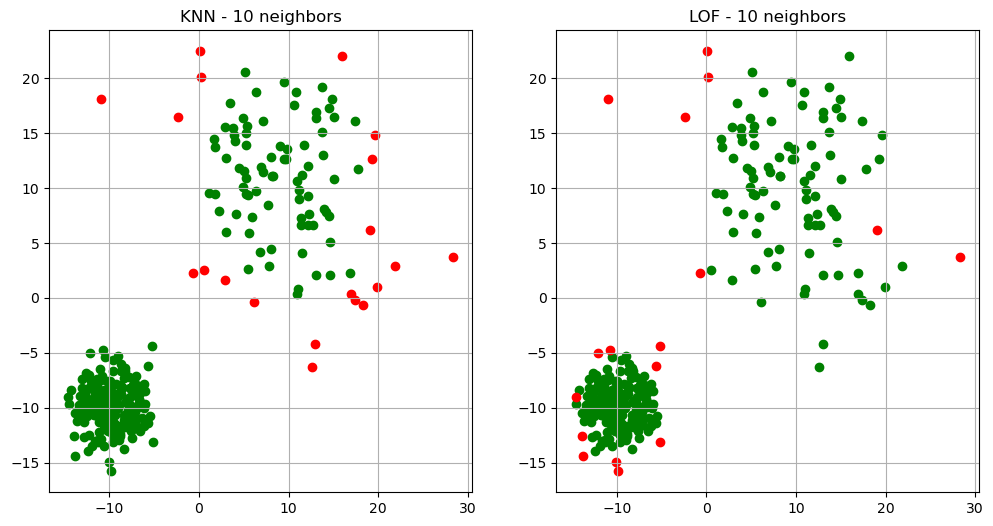

In [31]:
n_neighbors = [3, 5, 8, 10]
for nn in n_neighbors:
    knn_pred = knn(nn)
    lof_pred = lof(nn)

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].scatter(x[knn_pred == 0][:, 0], x[knn_pred == 0][:, 1], color='green')
    axs[0].scatter(x[knn_pred == 1][:, 0], x[knn_pred == 1][:, 1], color='red')
    axs[0].set_title(f'KNN - {nn} neighbors')
    axs[0].grid()

    axs[1].scatter(x[lof_pred == 0][:, 0], x[lof_pred == 0][:, 1], color='green')
    axs[1].scatter(x[lof_pred == 1][:, 0], x[lof_pred == 1][:, 1], color='red')
    axs[1].set_title(f'LOF - {nn} neighbors')
    axs[1].grid()

    plt.show()

Ex 4

In [34]:
data = loadmat("cardio.mat")
x = data['X'] 
y = data['y'].ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std 

In [36]:
n_neighbors = [30,40,50,60,70,80,90,100,110,120]
train_scores = [] 
test_scores = []

for nn in n_neighbors:
    knn = KNN(n_neighbors=nn, contamination=0.1)
    knn.fit(x_train)

    y_train_pred = knn.predict(x_train)
    y_test_pred = knn.predict(x_test)

    train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
    print(f"BA for {nn} neighbors: train data - {train_accuracy}, test data - {test_accuracy}")
    
    train_scores.append(knn.decision_function(x_train))
    test_scores.append(knn.decision_function(x_test))

BA for 30 neighbors: train data - 0.6752484887155595, test data - 0.6816369606003753
BA for 40 neighbors: train data - 0.6906006083641825, test data - 0.694457473420888
BA for 50 neighbors: train data - 0.7067063075154429, test data - 0.694457473420888
BA for 60 neighbors: train data - 0.7187855818788882, test data - 0.7072779862414009
BA for 70 neighbors: train data - 0.719162371630207, test data - 0.7200984990619137
BA for 80 neighbors: train data - 0.7264616417031997, test data - 0.7457395247029392
BA for 90 neighbors: train data - 0.7308648562423337, test data - 0.7585600375234521
BA for 100 neighbors: train data - 0.7352680707814674, test data - 0.771380550343965
BA for 110 neighbors: train data - 0.7389177058179638, test data - 0.7842010631644778
BA for 120 neighbors: train data - 0.7389177058179638, test data - 0.7857254534083802


In [38]:
train_scores = np.array(train_scores).T 
test_scores = np.array(test_scores).T

train_scores, test_scores = standardizer(train_scores, test_scores)

train_scores_avg = average(train_scores)
test_scores_avg = average(test_scores)

train_scores_max = maximization(train_scores)
test_scores_max = maximization(test_scores)

In [40]:
threshold_avg = np.quantile(train_scores_avg, 0.9)
threshold_max = np.quantile(train_scores_max, 0.9)

y_test_pred_avg = test_scores_avg > threshold_avg
y_test_pred_max = test_scores_max > threshold_max

ba_avg = balanced_accuracy_score(y_test, y_test_pred_avg)
ba_max = balanced_accuracy_score(y_test, y_test_pred_max)

print(ba_avg)
print(ba_max)

0.7329190118824265
0.771380550343965
